In [1]:
##连接Spark
import taiji_ide #用于选择spark的版本
taiji_ide.set_spark(version="3.1.2",gaia_id="3527") #导入spark环境，选择spark版本
import os
from pyspark.sql import *
os.environ['GROUP_ID'] = 'g_wxg_wxa_wxa_offline_datamining'
os.environ['GAIA_ID'] = '3527'
session = SparkSession.builder.config('spark.driver.memory', '8g').config('spark.executor.cores', 4).config('spark.executor.memory', '8g').getOrCreate()

Driver Log Write In: /tmp/log/spark-e82a6f36-a259-4ed0-933f-60982094c04e.log
TDWHelper Tracking Url : http://tdwhelper.oa.com/resources_pool_status/app/yarn_app_heuristic.php?app_id=application_1702349667126_864197
Spark UI : http://application.tdw.oa.com:8080/proxy/application_1702349667126_864197


In [2]:
###
import tensorflow as tf
import logging
import argparse
import sys
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind

In [3]:
## spark 相关包
from commutil import spark_util
from commutil import tdw_util
from pyspark.sql.types import Row
from pytoolkit import TDWSQLProvider, TDWUtil, TDWProvider, TableDesc, TableInfo
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassificationModel,DecisionTreeClassificationModel,GBTClassificationModel,LogisticRegressionModel,LinearSVCModel,NaiveBayesModel
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
import sys
from commutil import spark_util
from commutil import tdw_util
from pytoolkit import TDWSQLProvider, TDWUtil, TDWProvider, TableDesc, TableInfo
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType, StringType
from pyspark.sql.functions import col,lit,split
import json
import argparse
import tensorflow as tf
from pyspark.sql import SparkSession
import os


'''
os.environ['GROUP_ID'] = 'g_wxg_wxplat_wxg_mmbiz_dw'
os.environ['GAIA_ID'] = '3651'
session = SparkSession.builder.config('spark.driver.memory', '16g').config('spark.executor.cores', 8).config('spark.executor.memory', '16g').getOrCreate()
spark = spark_util.session(app_name='dnn_classify')
dw_util = TDWUtil(dbName='wxg_mmbiz_dw')
db_name =  'wxg_mmbiz_dw'
table_name  = 'dwmid_daily_wxapp_short_moive_sample_feature_at' 
pri_parts = '20231111'
sample = tdw_util.read_df(spark, db_name=db_name, table_name=table_name, pri_parts=[pri_parts]).limit(100)
sample.show()
'''

"\nos.environ['GROUP_ID'] = 'g_wxg_wxplat_wxg_mmbiz_dw'\nos.environ['GAIA_ID'] = '3651'\nsession = SparkSession.builder.config('spark.driver.memory', '16g').config('spark.executor.cores', 8).config('spark.executor.memory', '16g').getOrCreate()\nspark = spark_util.session(app_name='dnn_classify')\ndw_util = TDWUtil(dbName='wxg_mmbiz_dw')\ndb_name =  'wxg_mmbiz_dw'\ntable_name  = 'dwmid_daily_wxapp_short_moive_sample_feature_at' \npri_parts = '20231111'\nsample = tdw_util.read_df(spark, db_name=db_name, table_name=table_name, pri_parts=[pri_parts]).limit(100)\nsample.show()\n"

In [4]:
##读取tdw里的分区表--用户特征表
from pytoolkit import TDWSQLProvider
provider = TDWSQLProvider(session, group='tl', db='wxg_mmbiz_dw')
# priParts的分区填写要加上p_, 比如 priParts=['p_20231124']
provider.table('dwmid_daily_wxapp_short_moive_uin_stat_dyn_feature_at', priParts=['p_20231124']).createOrReplaceTempView('dwmid_daily_wxapp_short_moive_uin_stat_dyn_feature_at')
#转为pandas中的df
df_raw_0=session.sql('select * from dwmid_daily_wxapp_short_moive_uin_stat_dyn_feature_at').toPandas()
df_raw_0.head()

,ds,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,last_tonow,city_level,gender,age
0,20231124,14495796,0,60492,0,29290,13,2736,2,149,2,83,323.0,0.0,3-二线城市,2,58.0
1,20231124,17265464,0,0,0,0,2,25,1,5,1,5,123.0,0.0,None,None,NaN
2,20231124,130932187,0,7,0,0,2,4,1,3,1,3,310.0,0.0,4-三线城市,2,61.0
3,20231124,145143688,0,2470,0,0,1,45,1,8,1,6,314.0,0.0,6-五线城市,2,38.0
4,20231124,238190086,0,3992,0,0,52,185,1,3,1,5,316.0,0.0,3-二线城市,2,54.0


In [5]:
##读取tdw里的分区表--用户等级表
provider.table('dwmid_daily_wxapp_short_moive_uin_feature_level_at', priParts=['p_20231124']).createOrReplaceTempView('dwmid_daily_wxapp_short_moive_uin_feature_level_at')
#转为pandas中的df
df_level=session.sql('select * from dwmid_daily_wxapp_short_moive_uin_feature_level_at').toPandas()
df_level_copy=df_level.copy()
df_level

,ds,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,last_tonow,city_level,gender,age,active_level,pay_amount_level
0,20231124,103328,0,0,0,0,18,65,8,20,5,10,10.0,0.0,None,None,NaN,None,None
1,20231124,103822,0,1958,0,0,1,54,1,4,1,3,7.0,0.0,2-新一线城市,1,40.0,2-中活,None
2,20231124,103925,1,0,0,0,0,97,0,14,0,8,20.0,5.0,None,None,NaN,None,None
3,20231124,105680,0,4,0,0,0,0,0,0,0,0,NaN,NaN,9-国外其他,1,41.0,1-低活,None
4,20231124,106923,1,0,0,0,1,119,1,11,1,1,6.0,0.0,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991410,20231124,4162898844,0,1464,0,0,14,14,1,1,1,1,0.0,0.0,未知,0,0.0,2-中活,None
1991411,20231124,4162899312,0,230,0,0,15,15,1,1,1,1,0.0,0.0,未知,0,0.0,1-低活,None
1991412,20231124,4162908106,0,1463,0,0,0,44,0,1,0,1,1.0,1.0,未知,0,0.0,2-中活,None
1991413,20231124,4162912601,0,0,0,0,0,0,0,0,0,0,NaN,NaN,None,None,NaN,None,None


In [6]:
#导入的dataset的数据量
df_raw_0.groupby('treatment').count()

,ds,uin,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,last_tonow,city_level,gender,age
treatment,,,,,,,,,,,,,,,,
0,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1657471,1657471,1341543,1341543,1341543
1,263683,263683,263683,263683,263683,263683,263683,263683,263683,263683,263683,261630,261630,186687,186687,186687


In [7]:
###数据预处理
##缺失值的处理!!!!!!
# 计算 DataFrame 中每列的众数
mode_values = df_raw_0.mode().iloc[0]
# 用众数填充缺失数据
df_raw_0 = df_raw_0.fillna(mode_values)
df_raw_0 = df_raw_0.reset_index(drop=True)
df_raw = df_raw_0.drop(['ds'],axis=1)
# 删除包含null值的行
df_raw = df_raw.dropna()
#将treatment改为int型
df_raw['treatment'] = df_raw['treatment'].astype(int)
#重新设置df的索引
df = df_raw.reset_index(drop=True)
df_raw = df_raw.reset_index(drop=True)
#将gender列化为分类变量
df['gender'] = df['gender'].replace({'1': '男', '2': '女'})

#对分类变量进行独热编码
df = pd.get_dummies(df, columns=['city_level', 'gender'])


#对数值型变量进行标准化
# 初始化StandardScaler或MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

# 对数值型变量列进行归一化（或标准化）
numerical_columns = ['staytime_long','pay_amount_1d','pay_amount_30d','pv','history_pv','drama_num','history_drama_num','wxapp_num','history_wxapp_num','first_tonow','last_tonow','age']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df_1=df
df.head()

,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,...,city_level_4-三线城市,city_level_5-四线城市,city_level_6-五线城市,city_level_7-五线以下城市,city_level_8-港澳台,city_level_9-国外其他,city_level_未知,gender_0,gender_女,gender_男
0,14495796,0,0.030840,0.0,0.014383,0.004175,0.025866,0.011696,0.069920,0.014493,...,0,0,0,0,0,0,0,0,1,0
1,17265464,0,0.000000,0.0,0.000000,0.000642,0.000236,0.005848,0.002346,0.007246,...,1,0,0,0,0,0,0,0,0,1
2,130932187,0,0.000004,0.0,0.000000,0.000642,0.000038,0.005848,0.001408,0.007246,...,1,0,0,0,0,0,0,0,1,0
3,145143688,0,0.001259,0.0,0.000000,0.000321,0.000425,0.005848,0.003754,0.007246,...,0,0,1,0,0,0,0,0,1,0
4,238190086,0,0.002035,0.0,0.000000,0.016699,0.001749,0.005848,0.001408,0.007246,...,0,0,0,0,0,0,0,0,1,0


In [8]:
df.groupby('treatment').count()

,uin,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,...,city_level_4-三线城市,city_level_5-四线城市,city_level_6-五线城市,city_level_7-五线以下城市,city_level_8-港澳台,city_level_9-国外其他,city_level_未知,gender_0,gender_女,gender_男
treatment,,,,,,,,,,,,,,,,,,,,,
0,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,...,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732,1727732
1,263683,263683,263683,263683,263683,263683,263683,263683,263683,263683,...,263683,263683,263683,263683,263683,263683,263683,263683,263683,263683


In [9]:
# 实验组/对照组各特征差异显著性 
#target_feature为目标特征y，treatment为是否实验组
def compare(df,target_feature,treatment):   
    df_control = df[df[treatment]==0]
    df_treatment = df[df[treatment]==1]
    # 查看两组的均值
    print(df_control[target_feature].mean(), df_treatment[target_feature].mean()) 
 
    # t检验
    _, p = ttest_ind(df_control[target_feature], df_treatment[target_feature])
    print(f'p={p:.3f}')
 
    # 输出是否差异是否显著
    alpha = 0.05  # 显著水平设为 0.05
    if p > alpha:
        print('两者分布无差异（没有足够的证据拒绝原假设）')
    else:
        print('两者分布差异显著（拒绝原假设）')

In [10]:
# 计算SMD的方法
def SMD(d1, d2):
    # 计算样本数量
    n1, n2 = len(d1), len(d2)
    # 计算样本方差
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # 计算两组合并的标准差
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # 计算均值差
    u1, u2 = np.mean(d1), np.mean(d2)
    # 计算SMD标准平均差
    return (u1 - u2) / s

#输入数据集各特征的SMD
#treatment字段为是否实验组，cols为变量名组成的list
def feature_SMD(df,treatment,cols):
    df_control = df[df[treatment]==0]
    df_treatment = df[df[treatment]==1]
    effect_sizes = []
    for cl in cols:
        _, p_before = ttest_ind(df_control[cl], df_treatment[cl])
        #_, p_after = ttest_ind(df_matched_control[cl], df_matched_treatment[cl])
        SMD_before = SMD(df_treatment[cl], df_control[cl])       #SMD的绝对值在0.1以下则可认为差距很小
        #SMD_after = SMD(df_matched_treatment[cl], df_matched_control[cl])
        effect_sizes.append([cl,'before', SMD_before, p_before])
        #effect_sizes.append([cl,'after', SMD_after, p_after])
    #结果改为df
    df_effect_sizes = pd.DataFrame([x for x in effect_sizes], columns=['feature', 'matching', 'SMD', 'p-value'])
    return df_effect_sizes

In [ ]:
###PSM所需的主函数

#训练LR模型，预测用户进入干预组的概率
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#用逻辑回归模型计算ps（可选其他分类model）
#可增加model的分类效果来评判分类模型的性能（可选其他分类model）！！！！！！！！！
def compute_ps(train_X,train_y,pred_X,pred_y,df):
    ##1.建立逻辑回归模型（可选其他分类model）
    lr = LogisticRegression(max_iter=1000)
    lr.fit(train_X, train_y)
    # 使用逻辑回归模型对X进行概率预测
    y_pred_proba = lr.predict_proba(pred_X)
    
    # 在训练集上进行预测
    train_y_pred = lr.predict(train_X)
    # 在预测集上进行预测
    pred_y_pred = lr.predict(pred_X)
    # 计算训练集和预测集上的准确性
    train_accuracy = accuracy_score(train_y, train_y_pred)
    pred_accuracy = accuracy_score(pred_y, pred_y_pred)
    # 显示结果
    print("Training set accuracy:", train_accuracy)
    print("Prediction set accuracy:", pred_accuracy) 
    
    ##2.添加psm得分
    df['ps']=y_pred_proba[:,1]
    return df


##4.用knn为实验组元素匹配样本
#a. 首先为每个元素都进行knn，匹配得分范围在25%标准差内的10个最近的元素
from sklearn.neighbors import NearestNeighbors

def match(df,n_neighbors,ratio):
    #n_neighbors为匹配的元素个数，ratio为半径系数，caliper=np.std(df[ps])*ratio，ps为预测得分的列名
    #i：以ps得分标准差的25%作为半径，匹配相邻的10个元素，半径越大或者k越大，可匹配到的元素越多
    caliper = np.std(df['ps']) * ratio
    print(f'caliper (radius) is: {caliper:.4f}')
 
    #ii：拟合knn
    knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)
    ps = df[['ps']]  
    knn.fit(ps)
 
    #iii：返回每个点相邻点的索引和距离
    #distances：一个二维数组，其中每一行对应于 ps 中的一个点，每一列对应于该点的一个最近邻居。数组中的值是点与其最近邻居之间的距离。
    #neighbor_indexes：一个二维数组，与 distances 的形状相同。数组中的值是 ps 中点的最近邻居的索引。
    distances, neighbor_indexes = knn.kneighbors(ps)  
    
    #b.为实验组中的每个元素，在对照组中找到一个和它匹配的
    matched_control = []  # 保存对照组中匹配到的观测对象
 
    for current_index in df.index:  # 遍历df中的每行
        if df.loc[current_index,'treatment'] == 0:   # 如果当前行是对照组
            df.loc[current_index, 'matched'] = np.nan  # 将匹配到的对象设置为nan
        else:    # 如果当前行是实验组
            for idx in neighbor_indexes[current_index,:]: # 遍历实验组元素的10个最相邻元素，插入一个最近的符合条件的对照组样本
                # 排除10个相邻元素中的自己，且确保相邻元素都是对照组
                if (current_index != idx) and (df.loc[idx,'treatment'] == 0):
                    if idx not in matched_control:  # 且当前对象没被匹配过
                        df.loc[current_index, 'matched'] = idx  # 记录当前的匹配对象
                        matched_control.append(idx)  # 并将其插入到待保存的数组中
                        break
    return df

##可匹配重复的对照组个体
def match_0(df,n_neighbors,ratio):
    #n_neighbors为匹配的元素个数，ratio为半径系数，caliper=np.std(df[ps])*ratio，ps为预测得分的列名
    #i：以ps得分标准差的25%作为半径，匹配相邻的10个元素，半径越大或者k越大，可匹配到的元素越多
    caliper = np.std(df['ps']) * ratio
    print(f'caliper (radius) is: {caliper:.4f}')
 
    #ii：拟合knn
    knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)
    ps = df[['ps']]  
    knn.fit(ps)
 
    #iii：返回每个点相邻点的索引和距离
    #distances：一个二维数组，其中每一行对应于 ps 中的一个点，每一列对应于该点的一个最近邻居。数组中的值是点与其最近邻居之间的距离。
    #neighbor_indexes：一个二维数组，与 distances 的形状相同。数组中的值是 ps 中点的最近邻居的索引。
    distances, neighbor_indexes = knn.kneighbors(ps)  
    
    #b.为实验组中的每个元素，在对照组中找到一个和它匹配的
    matched_control = []  # 保存对照组中匹配到的观测对象
 
    for current_index in df.index:  # 遍历df中的每行
        if df.loc[current_index,'treatment'] == 0:   # 如果当前行是对照组
            df.loc[current_index, 'matched'] = np.nan  # 将匹配到的对象设置为nan
        else:    # 如果当前行是实验组
            for idx in neighbor_indexes[current_index,:]: # 遍历实验组元素的10个最相邻元素，插入一个最近的符合条件的对照组样本
                # 排除10个相邻元素中的自己，且确保相邻元素都是对照组
                if (current_index != idx) and (df.loc[idx,'treatment'] == 0):
                    df.loc[current_index, 'matched'] = idx  # 记录当前的匹配对象
                    matched_control.append(idx)  # 并将其插入到待保存的数组中
                    break
    return df

##分层匹配
def match_1(df,n_neighbors,ratio):
    #n_neighbors为匹配的元素个数，ratio为半径系数，caliper=np.std(df[ps])*ratio，ps为预测得分的列名
    #i：以ps得分标准差的25%作为半径，匹配相邻的10个元素，半径越大或者k越大，可匹配到的元素越多
    caliper = np.std(df['ps']) * ratio
    print(f'caliper (radius) is: {caliper:.4f}')
 
    #ii：拟合knn
    knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)
    ps = df[['ps']]  
    knn.fit(ps)
 
    #iii：返回每个点相邻点的索引和距离
    #distances：一个二维数组，其中每一行对应于 ps 中的一个点，每一列对应于该点的一个最近邻居。数组中的值是点与其最近邻居之间的距离。
    #neighbor_indexes：一个二维数组，与 distances 的形状相同。数组中的值是 ps 中点的最近邻居的索引。
    distances, neighbor_indexes = knn.kneighbors(ps)  
    original_indexes = df.iloc[neighbor_indexes.flatten()].index.values.reshape(neighbor_indexes.shape)
    #b.为实验组中的每个元素，在对照组中找到一个和它匹配的
    matched_control = []  # 保存对照组中匹配到的观测对象
 
    for current_index in df.index:  # 遍历df中的每行
        if df.loc[current_index,'treatment'] == 0:   # 如果当前行是对照组
            df.loc[current_index,'matched'] = np.nan  # 将匹配到的对象设置为nan
        else:    # 如果当前行是实验组
            for idx in original_indexes[df.index.get_loc(current_index),:]: # 遍历实验组元素的10个最相邻元素，插入一个最近的符合条件的对照组样本
                # 排除10个相邻元素中的自己，且确保相邻元素都是对照组
                if (current_index != idx) and (df.loc[idx,'treatment'] == 0):
                    if idx not in matched_control:  # 且当前对象没被匹配过
                        df.loc[current_index, 'matched'] = idx  # 记录当前的匹配对象
                        matched_control.append(idx)  # 并将其插入到待保存的数组中
                        break
    return df

##5.对比匹配前后各个特征在实验组、对照组上的SMD的绝对值、p值
#tm为是否为实验组的列名，cols为数据集特征构成的list
def feature_SMD_before_after(df,treatment,cols):
    df[treatment] = df[treatment].astype(int)
    df_control = df[df[treatment]==0]
    df_treatment = df[df[treatment]==1]
    df_matched_treatment=df[df['matched'].notna()]
    df_matched_control=df.loc[df['matched'].dropna().astype(int)]
    group_names = {'匹配前对照组数目': df_control,'匹配前实验组数目': df_treatment,'匹配后对照组数目': df_matched_control,'匹配后实验组数目': df_matched_treatment}
    for name, df in group_names.items():
        print(f'{name}: {len(df)}')
    effect_sizes = []

    for cl in cols:
        _, p_before = ttest_ind(df_control[cl], df_treatment[cl])
        _, p_after = ttest_ind(df_matched_control[cl], df_matched_treatment[cl])
        SMD_before = abs(SMD(df_treatment[cl], df_control[cl]) )      #SMD的绝对值在0.1以下则可认为差距很小
        SMD_after = abs(SMD(df_matched_treatment[cl], df_matched_control[cl]))
        effect_sizes.append([cl,'before', SMD_before, p_before])
        effect_sizes.append([cl,'after', SMD_after, p_after])
    #结果改为df
    df_effect_sizes = pd.DataFrame([x for x in effect_sizes], columns=['feature', 'matching', 'SMD', 'p-value'])
    return df_effect_sizes


In [12]:
#查看匹配前两组的差异及显著性
compare(df_raw,'pv','treatment')

35.591140292591675 37.279183716811474
p=0.000
两者分布差异显著（拒绝原假设）


In [13]:
#查看为匹配前两组各协变量之间的差异情况
cols = ['staytime_long','pay_amount_1d','pay_amount_30d','pv','history_pv','drama_num','history_drama_num','wxapp_num','history_wxapp_num','first_tonow','last_tonow','age']
feature_SMD(df,'treatment',cols)

,feature,matching,SMD,p-value
0,staytime_long,before,0.469569,0.000000e+00
1,pay_amount_1d,before,0.045277,5.480915e-104
2,pay_amount_30d,before,0.416285,0.000000e+00
3,pv,before,0.021318,2.066449e-24
4,history_pv,before,0.552332,0.000000e+00
5,drama_num,before,-0.174489,0.000000e+00
6,history_drama_num,before,0.688113,0.000000e+00
7,wxapp_num,before,-0.419734,0.000000e+00
8,history_wxapp_num,before,1.014904,0.000000e+00
9,first_tonow,before,0.314132,0.000000e+00


In [14]:
#XGB模型
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

#把数据集分为训练集和测试集，训练集用来训练模型，测试集用来测试模型的效果
seed = 20231212
# 计算 'treatment' 列等于 1 的数据的数量
count_treatment_1 = (df['treatment'] == 1).sum()

# 从 'treatment' 列为 0 的数据中随机选择与 'treatment' 列等于 1 的数据的数量相同的数据
df1 = df[df['treatment'] == 0].sample(n=count_treatment_1)

# 将 'treatment' 列为 1 的数据与 df1 合并以创建新的 DataFrame df2
df2 = pd.concat([df1,df[df['treatment'] == 1]], ignore_index=True)

#不加入pv列
X = df2.drop(['treatment','uin'], axis=1)
Y = df2['treatment']

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.33, 
                                                    random_state=seed)

# 直接使用xgboost开源项目中封装好的分类器和回归器，可以直接使用XGBClassifier建立模型
# 可视化测试集的loss
# 改为True就能可视化loss
xgboost_model = XGBClassifier()
eval_set = [(X_test, y_test)]
xgboost_model.fit(X_train, 
                  y_train, 
                  early_stopping_rounds=10, 
                  eval_metric="logloss",  # 损失函数的类型，分类一般都是用对数作为损失函数
                  eval_set=eval_set,
                  verbose=False)

# xgboost的结果是每一个样本属于第一类的概率，要使用round将其转换为0 1值
y_pred = xgboost_model.predict( X_test )
predictions = [round(i) for i in y_pred] 

# 计算准确率，也就是把准确率作为衡量模型好坏的指标
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.45%


In [15]:
# XBG调参，随机搜索
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# 设定要调节的各参数组合的dict
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2,3,5,8],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] ,
    'subsample': [0.3,0.5,0.8,1.0],
}
#k折交叉验证
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

# 创建 XGBClassifier 模型
model = XGBClassifier()
# 创建 RandomizedSearchCV 对象
random_search = RandomizedSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, verbose=1,cv=kfold,n_iter=40)


# 使用训练数据进行网格搜索
random_result=random_search.fit(X_train, y_train)


# 输出最佳学习率和其对应的分数
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

# 使用最佳参数组合拟合模型
best_model = random_search.best_estimator_

# 预测测试集
y_pred = best_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best: 0.884441 using {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1}
Accuracy: 88.48%


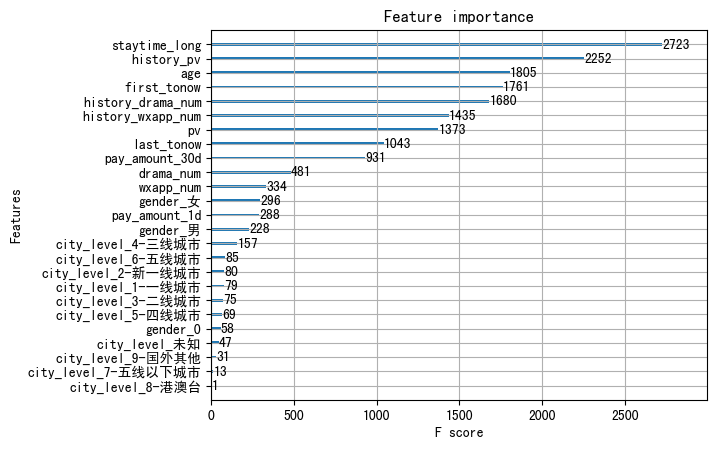

In [16]:
#XBG下特征重要性排序
from xgboost import plot_importance
from matplotlib import pyplot
best_model.fit(X, Y)
plot_importance( best_model )
pyplot.show()

In [17]:
# 预测测试集的概率
X_all=df.drop(['treatment','uin'], axis=1)
Y_all = df['treatment']
y_pred_proba = best_model.predict_proba(X_all)
df['ps']=y_pred_proba[:,1]
df

,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,...,city_level_5-四线城市,city_level_6-五线城市,city_level_7-五线以下城市,city_level_8-港澳台,city_level_9-国外其他,city_level_未知,gender_0,gender_女,gender_男,ps
0,14495796,0,0.030840,0.000000,0.014383,0.004175,0.025866,0.011696,0.069920,0.014493,...,0,0,0,0,0,0,0,1,0,0.903079
1,17265464,0,0.000000,0.000000,0.000000,0.000642,0.000236,0.005848,0.002346,0.007246,...,0,0,0,0,0,0,0,0,1,0.078397
2,130932187,0,0.000004,0.000000,0.000000,0.000642,0.000038,0.005848,0.001408,0.007246,...,0,0,0,0,0,0,0,1,0,0.000843
3,145143688,0,0.001259,0.000000,0.000000,0.000321,0.000425,0.005848,0.003754,0.007246,...,0,1,0,0,0,0,0,1,0,0.187464
4,238190086,0,0.002035,0.000000,0.000000,0.016699,0.001749,0.005848,0.001408,0.007246,...,0,0,0,0,0,0,0,1,0,0.017736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991410,3464284759,0,0.024254,0.000000,0.000000,0.008349,0.021980,0.011696,0.033787,0.007246,...,1,0,0,0,0,0,0,1,0,0.173433
1991411,3475474383,0,0.016653,0.012693,0.007828,0.010918,0.014465,0.011696,0.034725,0.014493,...,0,0,0,0,0,0,0,0,1,0.259916
1991412,3634402702,0,0.235972,0.000000,0.010676,0.123314,0.074790,0.040936,0.057719,0.007246,...,0,0,0,0,0,0,0,0,1,0.730809
1991413,3645680931,0,0.018861,0.000000,0.000000,0.009955,0.011657,0.017544,0.051619,0.014493,...,0,0,0,0,0,0,0,0,1,0.174867


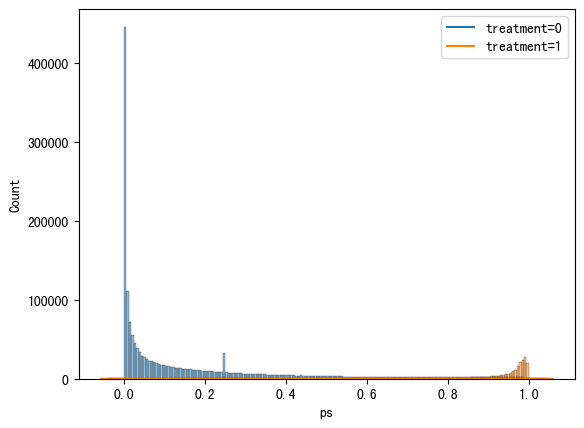

In [18]:
##查看预测ps后实验组和对照组ps的分布
sns.histplot(data=df, x='ps', hue='treatment')
# 在直方图上添加概率分布曲线
sns.kdeplot(data=df[df['treatment'] == 0]['ps'], label='treatment=0')
sns.kdeplot(data=df[df['treatment'] == 1]['ps'], label='treatment=1')
# 添加图例
plt.legend()
# 显示图形
plt.show()

In [19]:
#根据ps进行匹配，并输出匹配后的df
#参数分别为数据框，匹配个数n，ratio控制匹配半径
df=match(df,10,0.5)
df

caliper (radius) is: 0.1625


,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,...,city_level_6-五线城市,city_level_7-五线以下城市,city_level_8-港澳台,city_level_9-国外其他,city_level_未知,gender_0,gender_女,gender_男,ps,matched
0,14495796,0,0.030840,0.000000,0.014383,0.004175,0.025866,0.011696,0.069920,0.014493,...,0,0,0,0,0,0,1,0,0.903079,NaN
1,17265464,0,0.000000,0.000000,0.000000,0.000642,0.000236,0.005848,0.002346,0.007246,...,0,0,0,0,0,0,0,1,0.078397,NaN
2,130932187,0,0.000004,0.000000,0.000000,0.000642,0.000038,0.005848,0.001408,0.007246,...,0,0,0,0,0,0,1,0,0.000843,NaN
3,145143688,0,0.001259,0.000000,0.000000,0.000321,0.000425,0.005848,0.003754,0.007246,...,1,0,0,0,0,0,1,0,0.187464,NaN
4,238190086,0,0.002035,0.000000,0.000000,0.016699,0.001749,0.005848,0.001408,0.007246,...,0,0,0,0,0,0,1,0,0.017736,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991410,3464284759,0,0.024254,0.000000,0.000000,0.008349,0.021980,0.011696,0.033787,0.007246,...,0,0,0,0,0,0,1,0,0.173433,NaN
1991411,3475474383,0,0.016653,0.012693,0.007828,0.010918,0.014465,0.011696,0.034725,0.014493,...,0,0,0,0,0,0,0,1,0.259916,NaN
1991412,3634402702,0,0.235972,0.000000,0.010676,0.123314,0.074790,0.040936,0.057719,0.007246,...,0,0,0,0,0,0,0,1,0.730809,NaN
1991413,3645680931,0,0.018861,0.000000,0.000000,0.009955,0.011657,0.017544,0.051619,0.014493,...,0,0,0,0,0,0,0,1,0.174867,NaN


In [20]:
##将匹配结果带入原始数据框中，可得到对应uin
df_raw_0['matched']=df['matched']
matched = df_raw_0['matched'].dropna()
df_raw_0_copy=df_raw_0.copy()
df_raw_0_copy=df_raw_0_copy[df_raw_0_copy['matched'].notnull()]
#完成匹配的实验组数据
df_raw_0_copy['matched_uin'] = df_raw_0.loc[matched, 'uin'].values
df_raw_0_copy

,ds,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,last_tonow,city_level,gender,age,matched,matched_uin
71,20231124,181075721,1,102201,0,5160,2,1439,1,108,1,67,322.0,0.0,3-二线城市,2,58.0,1472695.0,1562454121
72,20231124,230143091,1,0,0,0,0,6,0,3,0,3,321.0,2.0,4-三线城市,1,53.0,899782.0,561072135
73,20231124,426603695,1,0,0,0,0,72,0,1,0,2,96.0,96.0,4-三线城市,1,53.0,107327.0,55914499
74,20231124,438163001,1,2080,0,0,0,185,0,10,0,6,316.0,2.0,4-三线城市,1,21.0,1825663.0,1625351924
75,20231124,438502490,1,0,0,0,179,4828,5,214,5,159,323.0,0.0,4-三线城市,1,53.0,1826369.0,2173808928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991307,20231124,1046872994,1,27390,0,4860,136,2128,1,58,2,63,302.0,0.0,9-国外其他,1,61.0,772714.0,2552103401
1991315,20231124,2060888434,1,8698,0,0,3,281,1,81,1,7,323.0,0.0,2-新一线城市,1,47.0,981713.0,2704161611
1991317,20231124,2130675209,1,37182,0,4750,22,1834,2,67,2,58,323.0,0.0,4-三线城市,1,52.0,679465.0,653429219
1991321,20231124,2472674080,1,0,0,0,81,287,3,15,1,15,308.0,0.0,4-三线城市,1,53.0,908341.0,2627694627


<AxesSubplot:xlabel='ps', ylabel='Count'>

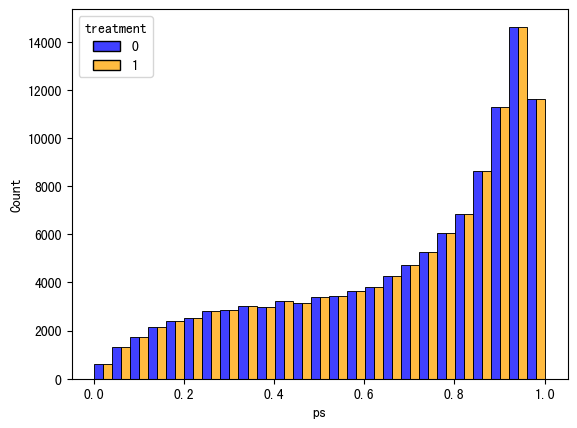

In [21]:
#查看匹配后的ps分布
union_df = pd.concat([df[df['matched'].notnull()], df.iloc[matched]], ignore_index=True)
sns.histplot(data=union_df, x='ps', hue='treatment',palette=['blue', 'orange'],binwidth=0.04, multiple='dodge')

In [22]:
#删除matched列
df_raw_0_copy = df_raw_0_copy.drop('matched', axis=1)
#变更列的类型为所创建的tdw表的列类型
df_raw_0_copy = df_raw_0_copy.astype({'first_tonow': 'int64', 'last_tonow': 'int64','age':'int64'})
##将匹配后的用户特征以及被匹配用户存储到一个tdw表！！！
#将pandas df转为spark df
df_raw_0_copy_sp=session.createDataFrame(df_raw_0_copy)
tdw_util.write_df(session,df_raw_0_copy_sp,'wxg_mmbiz_dw','dwmid_daily_wxapp_short_moive_uin_feature_match1_at','20231124') #match1为第二版，平衡后的匹配

In [23]:
#查看匹配前后数据集各特征的SMD
df_effect_sizes_1=feature_SMD_before_after(df_raw_0,'treatment',cols)
df_effect_sizes_1

匹配前对照组数目: 1727732
匹配前实验组数目: 263683
匹配后对照组数目: 116453
匹配后实验组数目: 116453


,feature,matching,SMD,p-value
0,staytime_long,before,0.469569,0.000000e+00
1,staytime_long,after,0.009597,2.057024e-02
2,pay_amount_1d,before,0.045277,5.480915e-104
3,pay_amount_1d,after,0.001873,6.512691e-01
4,pay_amount_30d,before,0.416285,0.000000e+00
5,pay_amount_30d,after,0.015728,1.476337e-04
6,pv,before,0.021318,2.066449e-24
7,pv,after,0.003297,4.263378e-01
8,history_pv,before,0.552332,0.000000e+00
9,history_pv,after,0.001052,7.996274e-01


<AxesSubplot:xlabel='SMD', ylabel='feature'>

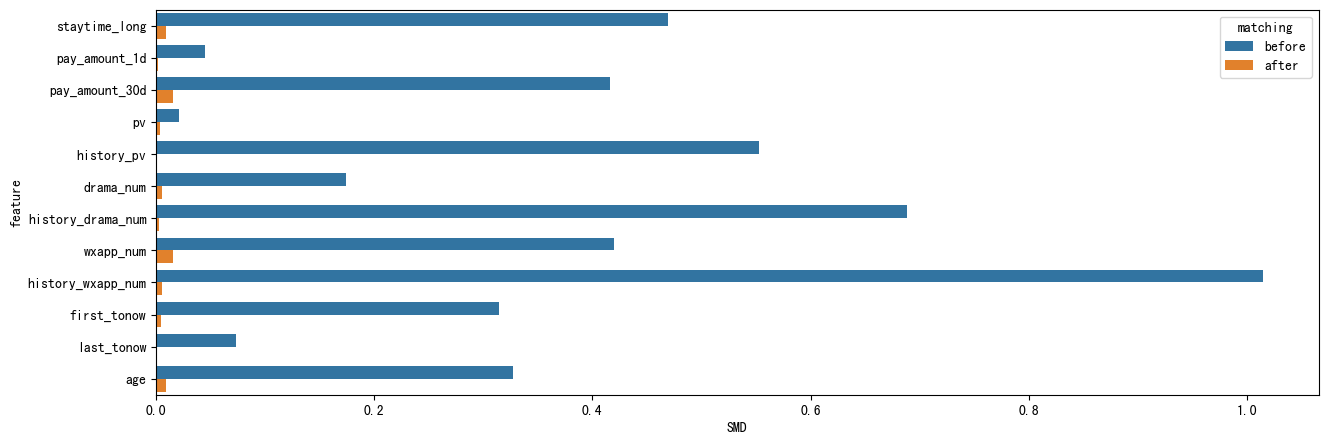

In [24]:
#用柱状图更直观的输出各特征SMD绝对值值的前后差异
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_effect_sizes_1, x='SMD', y='feature', hue='matching', orient='h')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


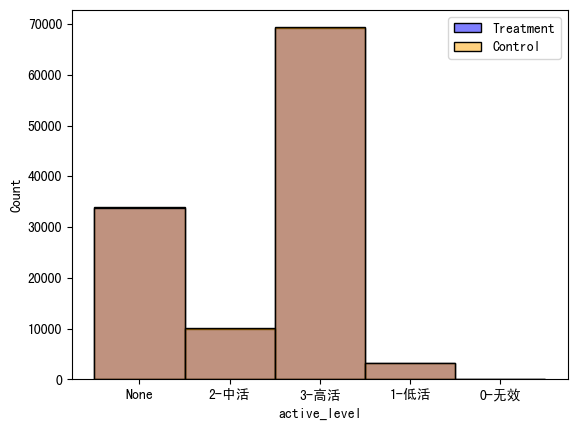

In [25]:
##检验匹配后的实验组和对照组的用户活跃&交易等级
# 选取 df_level 中 uin 列的值属于 df_raw_0_copy 中 uin 列的数据
#用户活跃等级分布
treatment_data = df_level[df_level['uin'].isin(df_raw_0_copy['uin'])]
control_data = df_level[df_level['uin'].isin(df_raw_0_copy['matched_uin'])]
# 将 treatment_data 和 control_data 中 active_level 列的 None 值替换为 'None'
treatment_data['active_level'] = treatment_data['active_level'].fillna('None')
control_data['active_level'] = control_data['active_level'].fillna('None')

# 绘制 treatment_data 和 control_data 的 active_level 列的分布直方图
sns.histplot(x='active_level', data=treatment_data, color='blue', label='Treatment', alpha=0.5)
sns.histplot(x='active_level', data=control_data, color='orange', label='Control', alpha=0.5)

# 添加图例并显示图形
plt.legend()
plt.show()


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


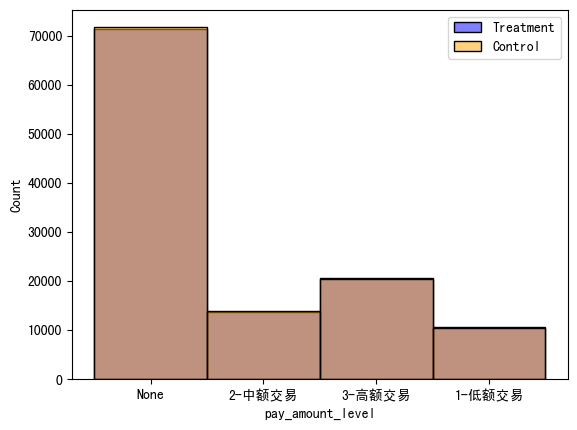

In [26]:
##检验匹配后的实验组和对照组的用户活跃&交易等级
##交易登记分布
# 使用 .loc[] 替换 None 值
treatment_data.loc[treatment_data['pay_amount_level'].isnull(), 'pay_amount_level'] = 'None'
control_data.loc[control_data['pay_amount_level'].isnull(), 'pay_amount_level'] = 'None'
# 绘制 treatment_data 和 control_data 的 active_level 列的分布直方图
sns.histplot(x='pay_amount_level', data=treatment_data, color='blue', label='Treatment', alpha=0.5)
sns.histplot(x='pay_amount_level', data=control_data, color='orange', label='Control', alpha=0.5)

# 添加图例
plt.legend()
# 显示图形
plt.show()

###Logistic模型

Training set accuracy: 0.7900035269622995
Prediction set accuracy: 0.8203197224084382


<AxesSubplot:xlabel='ps', ylabel='Count'>

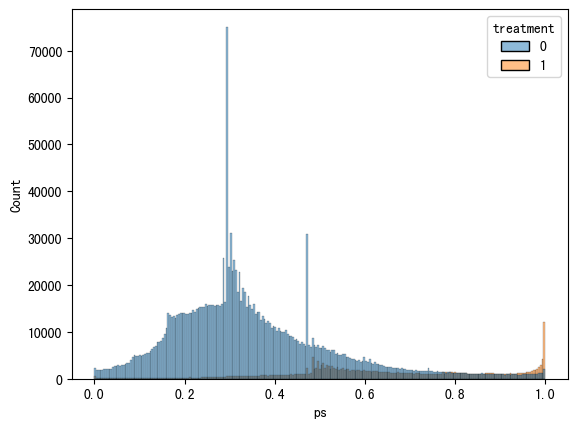

In [40]:
#Logistic模型数据准备

# 计算 'treatment' 列等于 1 的数据的数量
count_treatment_1 = (df['treatment'] == 1).sum()

# 从 'treatment' 列为 0 的数据中随机选择与 'treatment' 列等于 1 的数据的数量相同的数据
df1 = df[df['treatment'] == 0].sample(n=count_treatment_1)

# 将 'treatment' 列为 1 的数据与 df1 合并以创建新的 DataFrame df2
df2 = pd.concat([df1,df[df['treatment'] == 1]], ignore_index=True)

#不加入pv列
train_X = df2.drop(['treatment','uin'], axis=1)
train_y = df2['treatment']

pred_X=df.drop(['treatment','uin'], axis=1)
pred_y=df['treatment']
#计算ps得到新的df，并查看LR在训练集和测试集上的效果
df=compute_ps(train_X,train_y,pred_X,pred_y,df)
##3.查看实验组和对照组倾向得分的重叠度
sns.histplot(data=df, x='ps', hue='treatment')
#sns.histplot(data=df, x='ps', hue='treatment', multiple='dodge',binwidth=0.02)

###按用户活跃等级分层匹配

In [15]:
##按照用户活跃等级来分层分别进行匹配
df_list1=[]
for i in list(df_level['active_level'].unique()):
    selected_uins = df_level[df_level['active_level'] == i]['uin']
    if len(df[(df['uin'].isin(selected_uins)) &(df['treatment']==1) ]) >=1 and len(df[(df['uin'].isin(selected_uins)) &(df['treatment']==0) ]) >=1:
        df_list1.append(match_1(df[df['uin'].isin(selected_uins)],10,0.1))
# 将列表中的所有 DataFrame 元素合并为一个大的 DataFrame（ignore_index=False
df_stratify=pd.concat(df_list1, ignore_index=False)


caliper (radius) is: 0.0169


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


caliper (radius) is: 0.0143


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


caliper (radius) is: 0.0270


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


caliper (radius) is: 0.0125


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
df_stratify[df_stratify['matched'].notnull()]

,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,...,city_level_6-五线城市,city_level_7-五线以下城市,city_level_8-港澳台,city_level_9-国外其他,city_level_未知,gender_0,gender_女,gender_男,ps,matched
54,438163001,1,1.060436e-03,0.0,0.0,0.0,0.001740,0.0,0.004225,0.0,...,0,0,0,0,0,0,0,1,0.576865,667674.0
62,1068212442,1,3.298567e-04,0.0,0.0,0.0,0.000199,0.0,0.000469,0.0,...,0,0,0,0,0,0,0,1,0.539931,1215235.0
65,1573425161,1,6.117898e-04,0.0,0.0,0.0,0.000879,0.0,0.002347,0.0,...,0,0,0,0,0,0,1,0,0.582234,282560.0
68,1964422227,1,4.440574e-04,0.0,0.0,0.0,0.000558,0.0,0.002817,0.0,...,0,0,0,0,0,0,1,0,0.616192,198469.0
73,2309815263,1,9.605100e-04,0.0,0.0,0.0,0.000775,0.0,0.000939,0.0,...,1,0,0,0,0,0,1,0,0.676354,380579.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429457,1943660157,1,0.000000e+00,0.0,0.0,0.0,0.000170,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1,0.311873,1318201.0
1435268,2038865010,1,0.000000e+00,0.0,0.0,0.0,0.000321,0.0,0.000000,0.0,...,0,0,0,1,0,0,1,0,0.488262,1430730.0
1445823,2130025608,1,0.000000e+00,0.0,0.0,0.0,0.000019,0.0,0.000000,0.0,...,0,0,0,0,0,0,1,0,0.726209,43916.0
1461972,3462269816,1,0.000000e+00,0.0,0.0,0.0,0.000057,0.0,0.000000,0.0,...,0,0,0,0,0,1,0,0,0.794088,1002999.0


In [17]:
df_stratify['matched'].count()

145517

In [18]:
##将匹配结果带入原始数据框中，可得到对应uin
for index in df_raw_0.index:
    if index in df_stratify.index:
         df_raw_0.loc[index, 'matched']=df_stratify.loc[index, 'matched']
         if index in [10000,100000,1000000]:
            print(index)
matched = df_raw_0['matched'].dropna()
df_raw_0_copy=df_raw_0.copy()
df_raw_0_copy=df_raw_0_copy[df_raw_0_copy['matched'].notnull()]
#完成匹配的实验组数据
df_raw_0_copy['matched_uin'] = df_raw_0.loc[matched, 'uin'].values
df_raw_0_copy

10000
100000
1000000


,ds,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,last_tonow,city_level,gender,age,matched,matched_uin
53,20231124,181075721,1,102201,0,5160,2,1439,1,108,1,67,322.0,0.0,3-二线城市,2,58.0,1163834.0,1044299372
54,20231124,438163001,1,2080,0,0,0,185,0,10,0,6,316.0,2.0,4-三线城市,1,21.0,667674.0,2722680624
55,20231124,459800277,1,40215,0,8070,8,2315,5,73,3,73,316.0,0.0,4-三线城市,1,52.0,671194.0,2248663066
56,20231124,460882163,1,103907,0,51480,0,16554,0,446,0,46,323.0,1.0,2-新一线城市,1,24.0,152489.0,190714552
57,20231124,628326636,1,598352,3990,177060,148,24855,1,402,2,132,319.0,0.0,3-二线城市,2,37.0,734966.0,1840990394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480762,20231124,2987117327,1,2237,0,990,0,37,0,1,0,1,7.0,7.0,3-二线城市,2,42.0,1046597.0,884641573
1480763,20231124,3032039478,1,10546,0,0,0,364,0,10,0,14,119.0,1.0,4-三线城市,2,34.0,672754.0,392068703
1480764,20231124,3119180590,1,3733,0,0,0,168,0,10,0,5,112.0,6.0,5-四线城市,1,45.0,1308822.0,3681039636
1480765,20231124,3304341578,1,2850,0,0,0,53,0,3,0,2,6.0,5.0,3-二线城市,2,54.0,854629.0,1053306037


In [19]:
#变更列的类型为所创建的tdw表的列类型
df_raw_0_copy = df_raw_0_copy.astype({'first_tonow': 'int64', 'last_tonow': 'int64','age':'int64'})
df_raw_0_copy=df_raw_0_copy.drop('matched',axis=1)
df_raw_0_copy.dtypes

ds                   object
uin                   int64
treatment            object
staytime_long         int64
pay_amount_1d         int64
pay_amount_30d        int64
pv                    int64
history_pv            int64
drama_num             int64
history_drama_num     int64
wxapp_num             int64
history_wxapp_num     int64
first_tonow           int64
last_tonow            int64
city_level           object
gender               object
age                   int64
matched_uin           int64
dtype: object

In [20]:
##将匹配后的用户特征以及被匹配用户存储到一个tdw表！！！
#将pandas df转为spark df
df_raw_0_copy_sp=session.createDataFrame(df_raw_0_copy)
tdw_util.write_df(session,df_raw_0_copy_sp,'wxg_mmbiz_dw','dwmid_daily_wxapp_short_moive_uin_feature_match2_at','20231124') #match2为第三版，平衡后的匹配

###普通匹配

In [19]:
#根据ps进行匹配，并输出匹配后的df
#参数分别为数据框，匹配个数n，ratio控制匹配半径
df=match(df,10,0.1)

caliper (radius) is: 0.0325


In [20]:
df

,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,...,city_level_6-五线城市,city_level_7-五线以下城市,city_level_8-港澳台,city_level_9-国外其他,city_level_未知,gender_0,gender_女,gender_男,ps,matched
0,14495796,0,0.030840,0.000000,0.014383,0.004175,0.025866,0.011696,0.069920,0.014493,...,0,0,0,0,0,0,1,0,0.871906,NaN
1,17265464,0,0.000000,0.000000,0.000000,0.000642,0.000236,0.005848,0.002346,0.007246,...,0,0,0,0,0,0,0,1,0.074587,NaN
2,130932187,0,0.000004,0.000000,0.000000,0.000642,0.000038,0.005848,0.001408,0.007246,...,0,0,0,0,0,0,1,0,0.000485,NaN
3,145143688,0,0.001259,0.000000,0.000000,0.000321,0.000425,0.005848,0.003754,0.007246,...,1,0,0,0,0,0,1,0,0.136314,NaN
4,238190086,0,0.002035,0.000000,0.000000,0.016699,0.001749,0.005848,0.001408,0.007246,...,0,0,0,0,0,0,1,0,0.015308,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991410,3464284759,0,0.024254,0.000000,0.000000,0.008349,0.021980,0.011696,0.033787,0.007246,...,0,0,0,0,0,0,1,0,0.151843,NaN
1991411,3475474383,0,0.016653,0.012693,0.007828,0.010918,0.014465,0.011696,0.034725,0.014493,...,0,0,0,0,0,0,0,1,0.215174,NaN
1991412,3634402702,0,0.235972,0.000000,0.010676,0.123314,0.074790,0.040936,0.057719,0.007246,...,0,0,0,0,0,0,0,1,0.568931,NaN
1991413,3645680931,0,0.018861,0.000000,0.000000,0.009955,0.011657,0.017544,0.051619,0.014493,...,0,0,0,0,0,0,0,1,0.178604,NaN


In [21]:
#匹配结果
df[df['matched'].notnull()]

,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,...,city_level_6-五线城市,city_level_7-五线以下城市,city_level_8-港澳台,city_level_9-国外其他,city_level_未知,gender_0,gender_女,gender_男,ps,matched
71,181075721,1,0.052105,0.0,0.002534,0.000642,0.013604,0.005848,0.050680,0.007246,...,0,0,0,0,0,0,1,0,0.959644,1559913.0
72,230143091,1,0.000000,0.0,0.000000,0.000000,0.000057,0.000000,0.001408,0.000000,...,0,0,0,0,0,0,0,1,0.470733,1347457.0
73,426603695,1,0.000000,0.0,0.000000,0.000000,0.000681,0.000000,0.000469,0.000000,...,0,0,0,0,0,0,0,1,0.894638,991024.0
74,438163001,1,0.001060,0.0,0.000000,0.000000,0.001749,0.000000,0.004693,0.000000,...,0,0,0,0,0,0,0,1,0.947490,893275.0
75,438502490,1,0.000000,0.0,0.000000,0.057482,0.045644,0.029240,0.100422,0.036232,...,0,0,0,0,0,0,0,1,0.943884,1239887.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991317,2130675209,1,0.018956,0.0,0.002333,0.007065,0.017339,0.011696,0.031441,0.014493,...,0,0,0,0,0,0,0,1,0.518340,710947.0
1991321,2472674080,1,0.000000,0.0,0.000000,0.026012,0.002713,0.017544,0.007039,0.007246,...,0,0,0,0,0,0,0,1,0.250139,818901.0
1991326,2888660180,1,0.003041,0.0,0.000486,0.000000,0.001229,0.000000,0.000469,0.000000,...,0,0,0,0,0,0,1,0,0.895342,1661548.0
1991333,3635904051,1,0.001747,0.0,0.000000,0.000000,0.000189,0.000000,0.000469,0.000000,...,0,0,0,0,0,0,1,0,0.819696,973472.0


In [22]:
##将匹配结果带入原始数据框中，可得到对应uin
df_raw_0['matched']=df['matched']
matched = df_raw_0['matched'].dropna()
df_raw_0_copy=df_raw_0.copy()
df_raw_0_copy=df_raw_0_copy[df_raw_0_copy['matched'].notnull()]
#完成匹配的实验组数据
df_raw_0_copy['matched_uin'] = df_raw_0.loc[matched, 'uin'].values
df_raw_0_copy

,ds,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,last_tonow,city_level,gender,age,matched,matched_uin
71,20231124,181075721,1,102201,0,5160,2,1439,1,108,1,67,322.0,0.0,3-二线城市,2,58.0,1559913.0,52882657
72,20231124,230143091,1,0,0,0,0,6,0,3,0,3,321.0,2.0,4-三线城市,1,53.0,1347457.0,2977605836
73,20231124,426603695,1,0,0,0,0,72,0,1,0,2,96.0,96.0,4-三线城市,1,53.0,991024.0,784068217
74,20231124,438163001,1,2080,0,0,0,185,0,10,0,6,316.0,2.0,4-三线城市,1,21.0,893275.0,2811851822
75,20231124,438502490,1,0,0,0,179,4828,5,214,5,159,323.0,0.0,4-三线城市,1,53.0,1239887.0,3482506017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991317,20231124,2130675209,1,37182,0,4750,22,1834,2,67,2,58,323.0,0.0,4-三线城市,1,52.0,710947.0,1242540821
1991321,20231124,2472674080,1,0,0,0,81,287,3,15,1,15,308.0,0.0,4-三线城市,1,53.0,818901.0,9484090
1991326,20231124,2888660180,1,5965,0,990,0,130,0,1,0,1,2.0,2.0,4-三线城市,2,33.0,1661548.0,1961675174
1991333,20231124,3635904051,1,3426,0,0,0,20,0,1,0,1,1.0,1.0,1-一线城市,2,28.0,973472.0,1714685611


<AxesSubplot:xlabel='ps', ylabel='Count'>

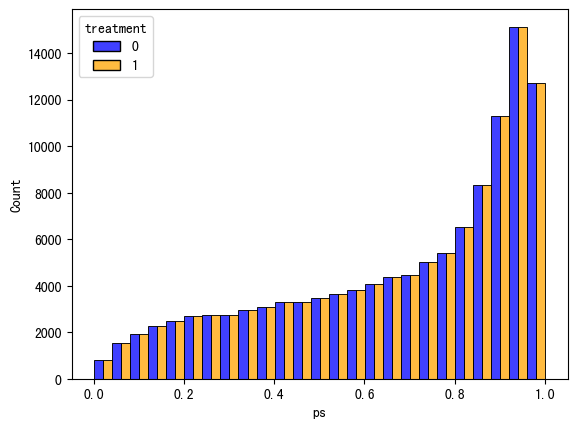

In [23]:
#查看匹配后的ps分布
union_df = pd.concat([df[df['matched'].notnull()], df.iloc[matched]], ignore_index=True)
sns.histplot(data=union_df, x='ps', hue='treatment',palette=['blue', 'orange'],binwidth=0.04, multiple='dodge')

In [24]:
#删除matched列
df_raw_0_copy = df_raw_0_copy.drop('matched', axis=1)
df_raw_0_copy

,ds,uin,treatment,staytime_long,pay_amount_1d,pay_amount_30d,pv,history_pv,drama_num,history_drama_num,wxapp_num,history_wxapp_num,first_tonow,last_tonow,city_level,gender,age,matched_uin
71,20231124,181075721,1,102201,0,5160,2,1439,1,108,1,67,322.0,0.0,3-二线城市,2,58.0,52882657
72,20231124,230143091,1,0,0,0,0,6,0,3,0,3,321.0,2.0,4-三线城市,1,53.0,2977605836
73,20231124,426603695,1,0,0,0,0,72,0,1,0,2,96.0,96.0,4-三线城市,1,53.0,784068217
74,20231124,438163001,1,2080,0,0,0,185,0,10,0,6,316.0,2.0,4-三线城市,1,21.0,2811851822
75,20231124,438502490,1,0,0,0,179,4828,5,214,5,159,323.0,0.0,4-三线城市,1,53.0,3482506017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991317,20231124,2130675209,1,37182,0,4750,22,1834,2,67,2,58,323.0,0.0,4-三线城市,1,52.0,1242540821
1991321,20231124,2472674080,1,0,0,0,81,287,3,15,1,15,308.0,0.0,4-三线城市,1,53.0,9484090
1991326,20231124,2888660180,1,5965,0,990,0,130,0,1,0,1,2.0,2.0,4-三线城市,2,33.0,1961675174
1991333,20231124,3635904051,1,3426,0,0,0,20,0,1,0,1,1.0,1.0,1-一线城市,2,28.0,1714685611


In [25]:
#变更列的类型为所创建的tdw表的列类型
df_raw_0_copy = df_raw_0_copy.astype({'first_tonow': 'int64', 'last_tonow': 'int64','age':'int64'})
df_raw_0_copy.dtypes

ds                   object
uin                   int64
treatment            object
staytime_long         int64
pay_amount_1d         int64
pay_amount_30d        int64
pv                    int64
history_pv            int64
drama_num             int64
history_drama_num     int64
wxapp_num             int64
history_wxapp_num     int64
first_tonow           int64
last_tonow            int64
city_level           object
gender               object
age                   int64
matched_uin           int64
dtype: object

In [26]:
##将匹配后的用户特征以及被匹配用户存储到一个tdw表！！！
#将pandas df转为spark df
df_raw_0_copy_sp=session.createDataFrame(df_raw_0_copy)
tdw_util.write_df(session,df_raw_0_copy_sp,'wxg_mmbiz_dw','dwmid_daily_wxapp_short_moive_uin_feature_match1_at','20231124') #match1为第二版，平衡后的匹配

In [27]:
#查看匹配前后数据集各特征的SMD
df_effect_sizes_1=feature_SMD_before_after(df_raw_0,'treatment',cols)
df_effect_sizes_1

匹配前对照组数目: 1727732
匹配前实验组数目: 263683
匹配后对照组数目: 118060
匹配后实验组数目: 118060


,feature,matching,SMD,p-value
0,staytime_long,before,0.469569,0.000000e+00
1,staytime_long,after,0.010353,1.188824e-02
2,pay_amount_1d,before,0.045277,5.480915e-104
3,pay_amount_1d,after,0.005518,1.800362e-01
4,pay_amount_30d,before,0.416285,0.000000e+00
5,pay_amount_30d,after,0.006095,1.386556e-01
6,pv,before,0.021318,2.066449e-24
7,pv,after,0.012756,1.941002e-03
8,history_pv,before,0.552332,0.000000e+00
9,history_pv,after,0.009959,1.553524e-02


<AxesSubplot:xlabel='SMD', ylabel='feature'>

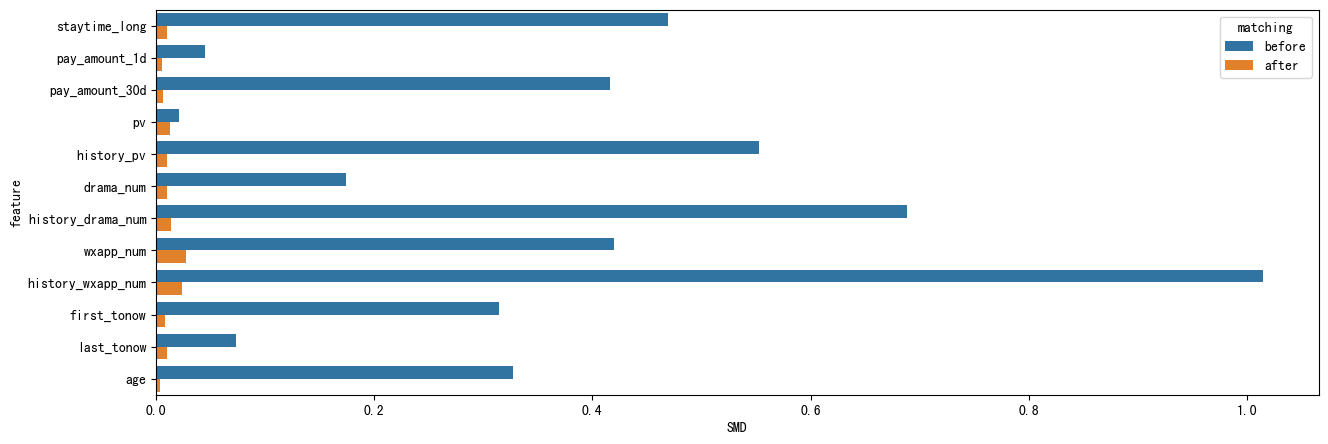

In [28]:
#用柱状图更直观的输出各特征SMD绝对值值的前后差异
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_effect_sizes_1, x='SMD', y='feature', hue='matching', orient='h')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


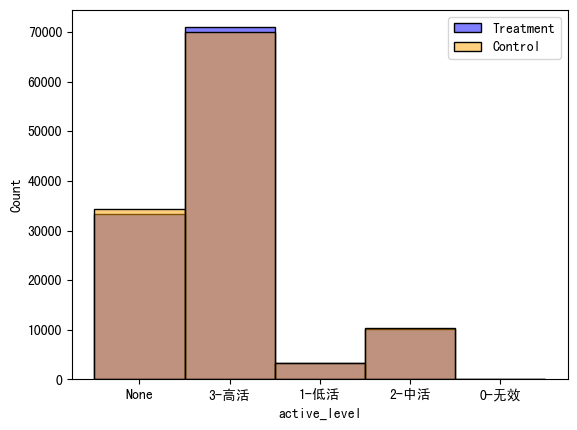

In [30]:
##检验匹配后的实验组和对照组的用户活跃&交易等级
# 选取 df_level 中 uin 列的值属于 df_raw_0_copy 中 uin 列的数据
#用户活跃等级分布
treatment_data = df_level[df_level['uin'].isin(df_raw_0_copy['uin'])]
control_data = df_level[df_level['uin'].isin(df_raw_0_copy['matched_uin'])]
# 将 treatment_data 和 control_data 中 active_level 列的 None 值替换为 'None'
treatment_data['active_level'] = treatment_data['active_level'].fillna('None')
control_data['active_level'] = control_data['active_level'].fillna('None')

# 绘制 treatment_data 和 control_data 的 active_level 列的分布直方图
sns.histplot(x='active_level', data=treatment_data, color='blue', label='Treatment', alpha=0.5)
sns.histplot(x='active_level', data=control_data, color='orange', label='Control', alpha=0.5)

# 添加图例并显示图形
plt.legend()
plt.show()


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


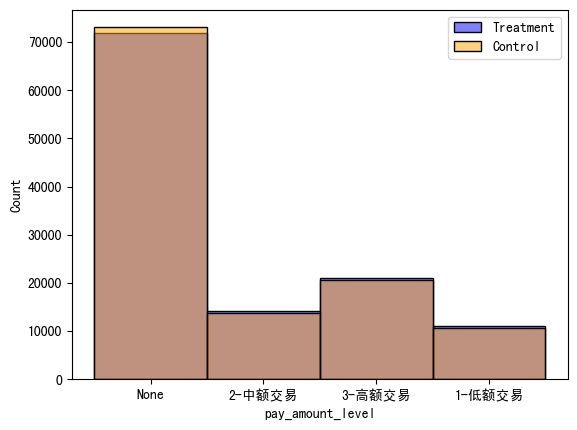

In [31]:
##检验匹配后的实验组和对照组的用户活跃&交易等级
##交易登记分布
# 使用 .loc[] 替换 None 值
treatment_data.loc[treatment_data['pay_amount_level'].isnull(), 'pay_amount_level'] = 'None'
control_data.loc[control_data['pay_amount_level'].isnull(), 'pay_amount_level'] = 'None'
# 绘制 treatment_data 和 control_data 的 active_level 列的分布直方图
sns.histplot(x='pay_amount_level', data=treatment_data, color='blue', label='Treatment', alpha=0.5)
sns.histplot(x='pay_amount_level', data=control_data, color='orange', label='Control', alpha=0.5)

# 添加图例
plt.legend()
# 显示图形
plt.show()